>### 🚩 *Create a free WhyLabs account to get more value out of whylogs!*<br> 
>*Did you know you can store, visualize, and monitor whylogs profiles with the [WhyLabs Observability Platform](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Monitor_Embeddings)? Sign up for a [free WhyLabs account](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Monitor_Embeddings) to leverage the power of whylogs and WhyLabs together!*

# Training-Serve Skew for ML Model Data

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/whylabs/whylogs/blob/mainline/python/examples/tutorials/Training_Serving_Skew.ipynb)

One important concept for production machine learning is eliminating training-serve skew. 

Simply put, this is the difference between performance of your machine model between the training stage and when production traffic is served by the model. However, there are different definitions for the concept. Some focus on differences in feature engineering or model implementation, others include distributional drift and feedback loops from the model's impact on future data traffic.

In this notebook, we'll demonstrate how to measure training-serving skew using whylogs and the WhyLabs Observability Platform.

## Setup

### Installing Dependencies

In [ ]:
# Note: You may need to restart the kernel to use updated packages.
!pip install whylogs[whylabs]

In [5]:
# Importing needed packages for all sections
import glob
import pandas as pd
import seaborn as sns
import whylogs as why

from whylogs.viz import NotebookProfileVisualizer

### Setting the Environment Variables for WhyLabs


In [6]:
import getpass
import os

# set your org-id here - should be something like "org-xxxx"
os.environ["WHYLABS_DEFAULT_ORG_ID"] = input("Enter your WhyLabs Org ID")

# set your datased_id (or model_id) here - should be something like "model-xxxx"
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = input("Enter your WhyLabs Dataset ID")

# set your API key here
os.environ["WHYLABS_API_KEY"] = getpass.getpass("Enter your WhyLabs API key")
print("Using API Key ID: ", os.environ["WHYLABS_API_KEY"][0:10])

Using API Key ID:  


### Downloading dataset and resources

In [7]:
!curl https://whylabs-public.s3.us-west-2.amazonaws.com/workshops/dcai_workshop_resources.zip > resources.zip
!unzip -o resources.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1447k  100 1447k    0     0  4412k      0 --:--:-- --:--:-- --:--:-- 4412k
Archive:  resources.zip
  inflating: datasets/best_ames.csv  
  inflating: datasets/improved_ames.csv  
  inflating: datasets/original_ames.csv  
  inflating: datasets/test_ames.csv  
  inflating: helpers.py              
  inflating: images/99_bathroom.jpg  
  inflating: images/99_bedroom.jpg   
  inflating: images/99_frontal.jpg   
  inflating: images/99_kitchen.jpg   
  inflating: images/all_bathroom_images.bin  
  inflating: images/all_bedroom_images.bin  
  inflating: images/all_frontal_images.bin  
  inflating: images/all_kitchen_images.bin  
  inflating: production/gen_ames_data.bin  
  inflating: production/gen_ames_data_2.bin  
  inflating: production/gen_ames_data_3.bin  
  inflating: production/gen_ames_data_4.bin  


## Scenario

For our running example, let's look at data with various differences between the training data and the data seen at inference time. Consider training your model on a nicely cleaned dataset with several transformations that we'll profile and inspect below.

We will use the [Ames housing](http://jse.amstat.org/v19n3/decock/AmesHousing.txt) dataset (De Cock 2011) provides tax assessor information and sale price for properties sold in Ames, Iowa between 2006 and 2010. The dataset comes with great [data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) for understanding the features -- statisticians seem to be much more thorough.

### Training data

In [9]:
# Loading clean training data
training_data = pd.read_csv("datasets/best_ames.csv")
training_data.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,63.0,8500,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,179600
1,80,RL,80.0,8000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,7,2009,WD,Normal,138000
2,30,RM,60.0,5400,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,120000
3,20,RL,70.0,7315,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,140000
4,120,RL,48.0,3242,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,200000


In [13]:
# Log dataset profiles for training dataset
training_results = why.log(training_data)
training_results.writer("whylabs").option(reference_profile_name="training").write()

A common pattern that causes training-serving skew is the differences in cleaning and data transformation between the two environments. While the above data has been highly transformed, we'll use the original (still altered) Ames data that represents the data seen at inference time.

### Inference data

In [14]:
# Loading batch of inference data
inference_data = pd.read_csv("datasets/test_ames.csv")
inference_data.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,50,RL,51.0,6191,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,112000
1,20,RL,NaN,10659,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2006,COD,Normal,136500
2,20,RL,39.0,16300,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,130000
3,20,RL,75.0,10650,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,128200
4,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,97000


In [15]:
# Log dataset profiles for inference data
batch_results = why.log(inference_data)
batch_results.writer("whylabs").write()

Both whylogs and WhyLabs provide helpful tools for finding differences between datasets caused by training-serve skew whether that be to distributional drift, schema change, and others.

We'll see some here starting by looking at a drift report.

In [16]:
# Create visualizer and generate drift report
viz = NotebookProfileVisualizer()
viz.set_profiles(target_profile_view=batch_results.profile().view(),
                 reference_profile_view=training_results.profile().view())
viz.summary_drift_report()

We can also show distribution comparisons for single features. This is helpful in investigating high drift features such as `Gr Liv Area`, the ground floor living area in square feet.

Let's look at those with the most drift.

In [17]:
viz.distribution_chart(feature_name="Sale Condition")

In [18]:
viz.distribution_chart(feature_name="MS Zoning")

In [19]:
viz.distribution_chart(feature_name="Sale Condition")

It's clear that we've found a number of transformations of the data present in the training data that are not the same in the inference environment. By training our data only on a subset of sale conditions and zoning scenarios, we're sure to have skew between training and inference environments!

We are able to monitor for these sorts of issues in the WhyLabs platform by setting a distribution drift on our features. You can do so with a convenient monitor preset for Drift as well as other interesting monitor scenarios!

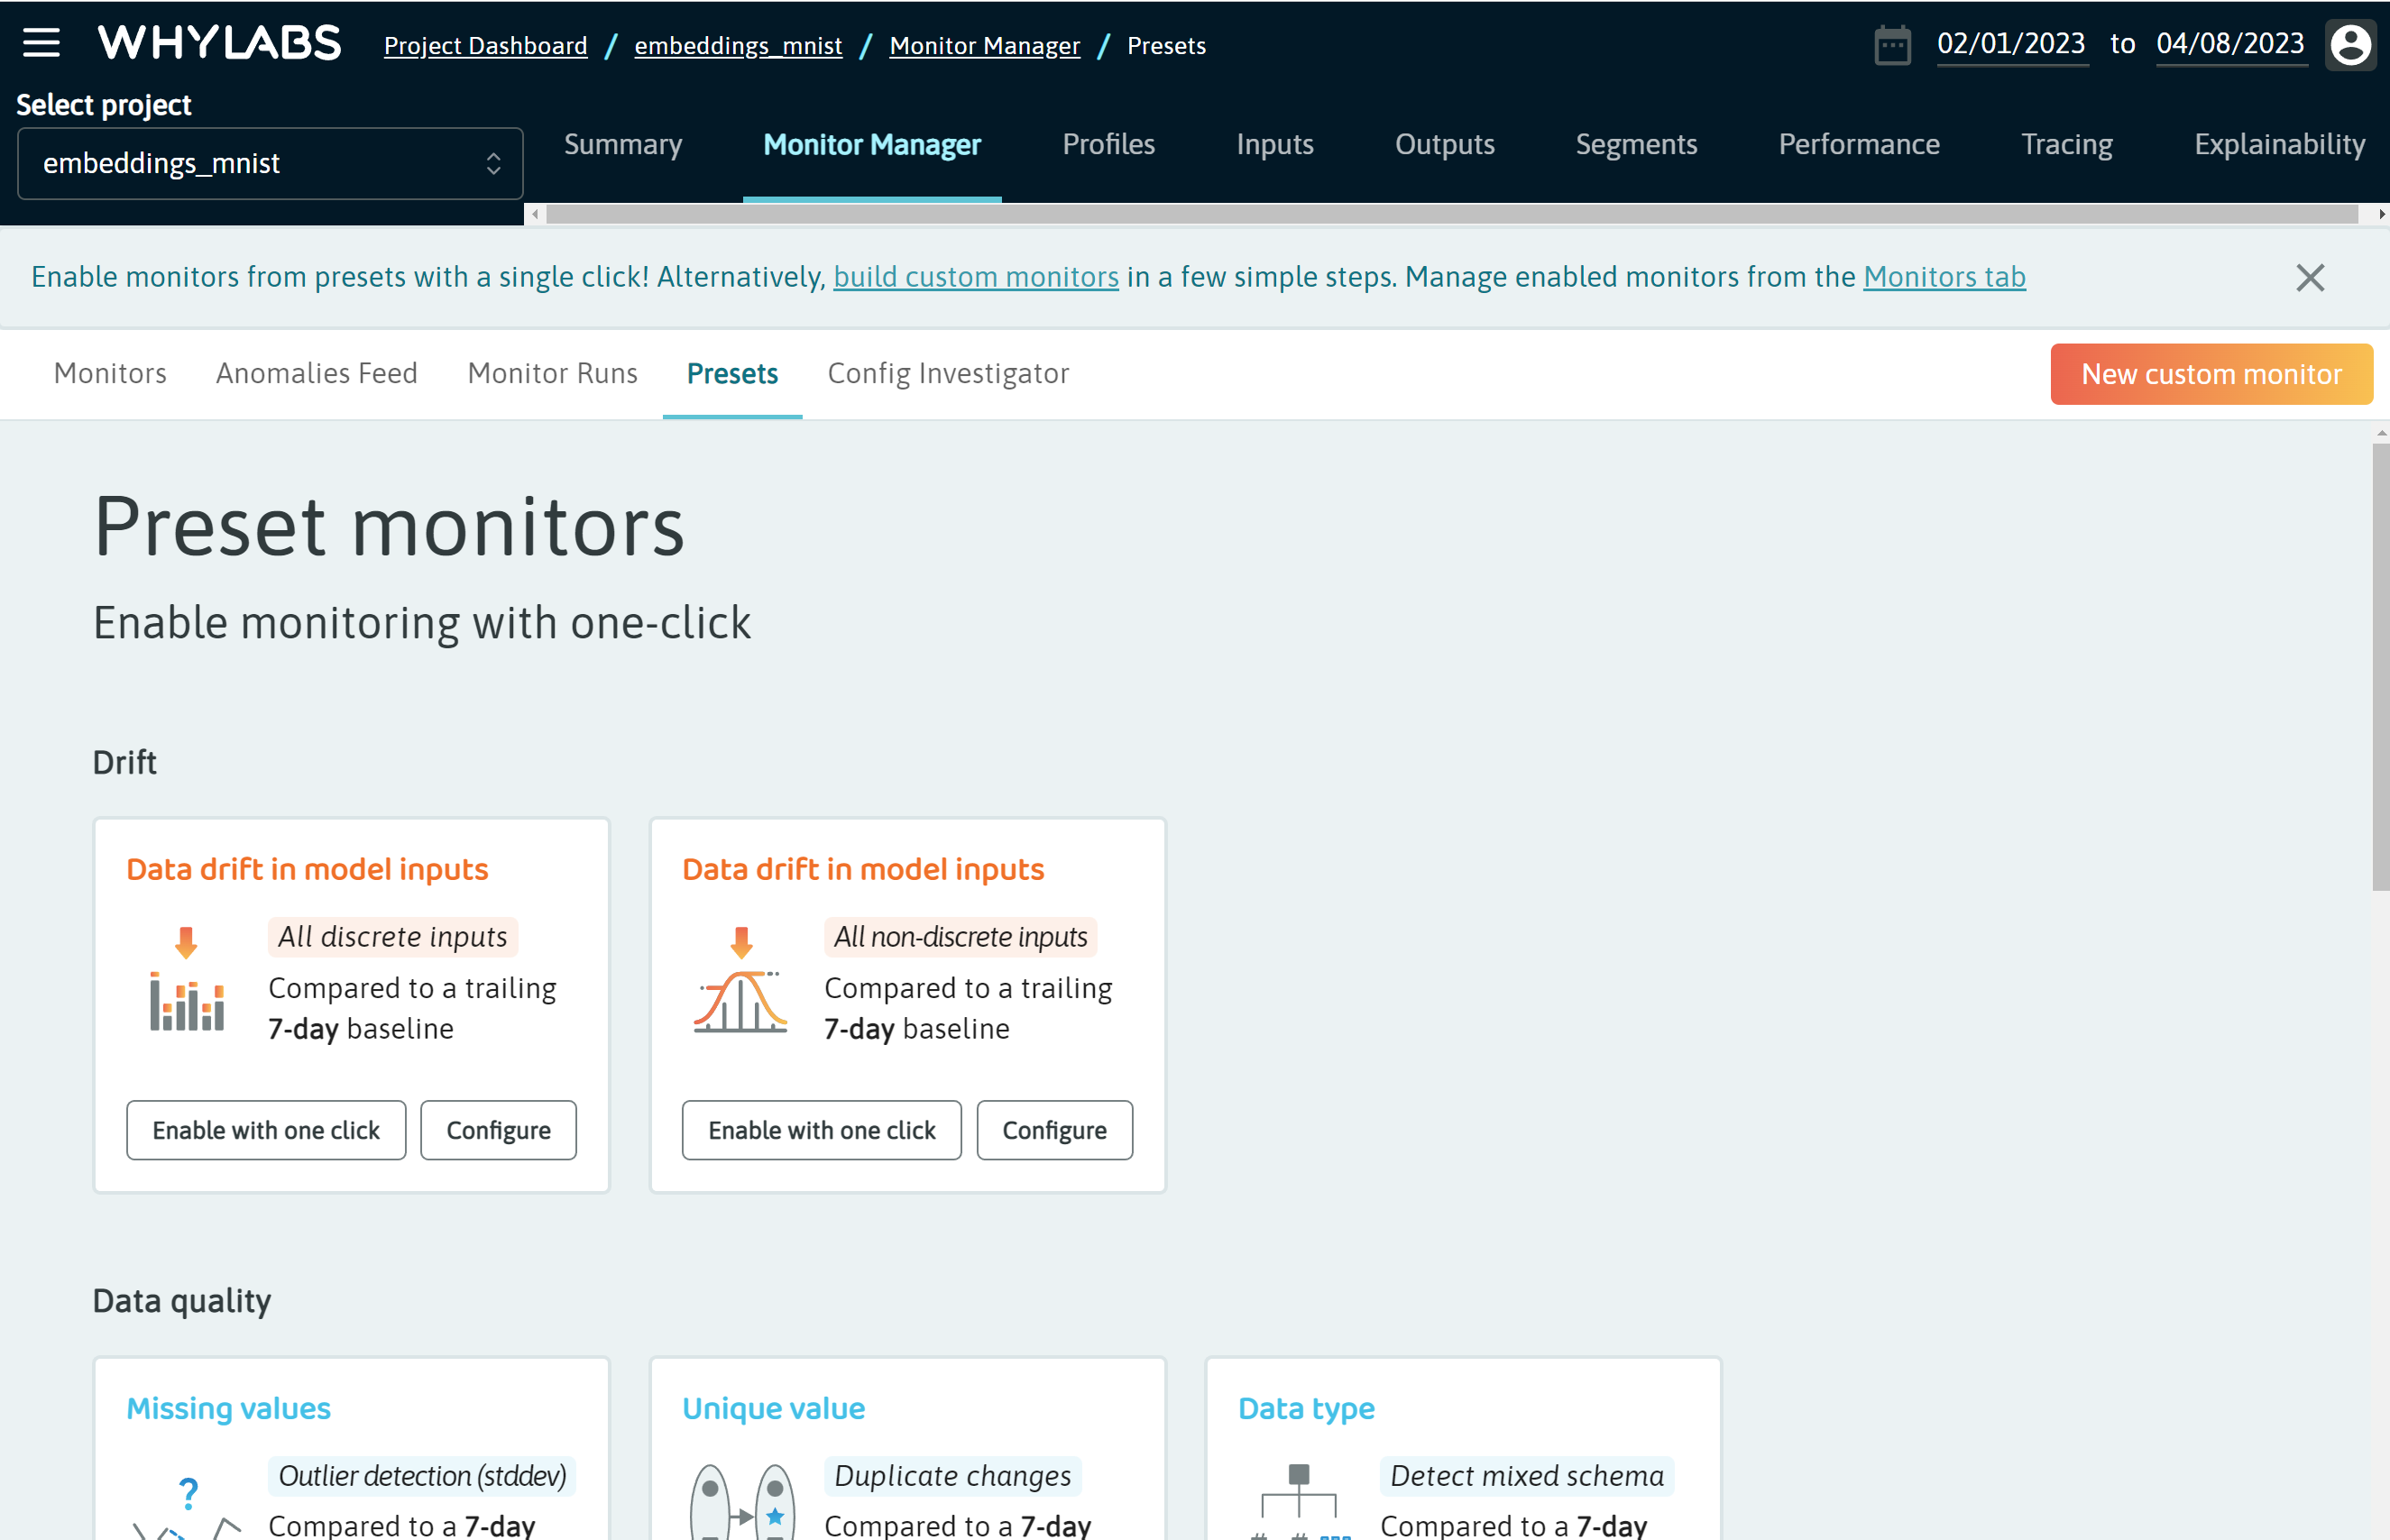